#### This is an example code of plotting velocity vectors.

To draw velocity vectors, you need **rotation file(s)** and **plate topology file(s)**.

The **coastlines** are just for decoration purpose. You may choose not to draw them.

The **velocity_utils.py** contains code to get velocity data. The file must in the currect working directory or in Python path.

The **pygplates** must be installed https://sourceforge.net/projects/gplates/files/pygplates/beta-revision-28/

You need **numpy**, **matplotlib**, **cartopy** and **shapely** to run this script.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
from shapely.geometry.polygon import LinearRing

import sys
sys.path.append('../../')

import velocity_tools, pygplates

rotation_files = ['../data/Global_EarthByte_230-0Ma_GK07_AREPS.rot']
topology_files = ['../data/Global_EarthByte_230-0Ma_GK07_AREPS_PlateBoundaries.gpmlz',
                 '../data/Global_EarthByte_230-0Ma_GK07_AREPS_Topology_BuildingBlocks.gpmlz']
coastlines = ['../data/Matthews_etal_GPC_2016_Coastlines.gpmlz']

time=0

#options to draw coastlines
#coastlines will not be drawn if setting both of the below variables to False 
draw_coastlines_as_polygon=False #very slow
draw_coastlines_as_polyline=False #not very slow

#### the code cell below resolve topologies and reconstruct coastlines

In [2]:
resolved_topologies = []
shared_boundary_sections = []
#use pygplates to resolve the topologies
pygplates.resolve_topologies(topology_files, rotation_files, resolved_topologies, time, 
                             shared_boundary_sections)

#reconstruct coastlines
if draw_coastlines_as_polygon or draw_coastlines_as_polyline:
    reconstructed_geometries = []
    pygplates.reconstruct(
                coastlines, 
                rotation_files, 
                reconstructed_geometries, 
                time, 0)

#### Plot the map

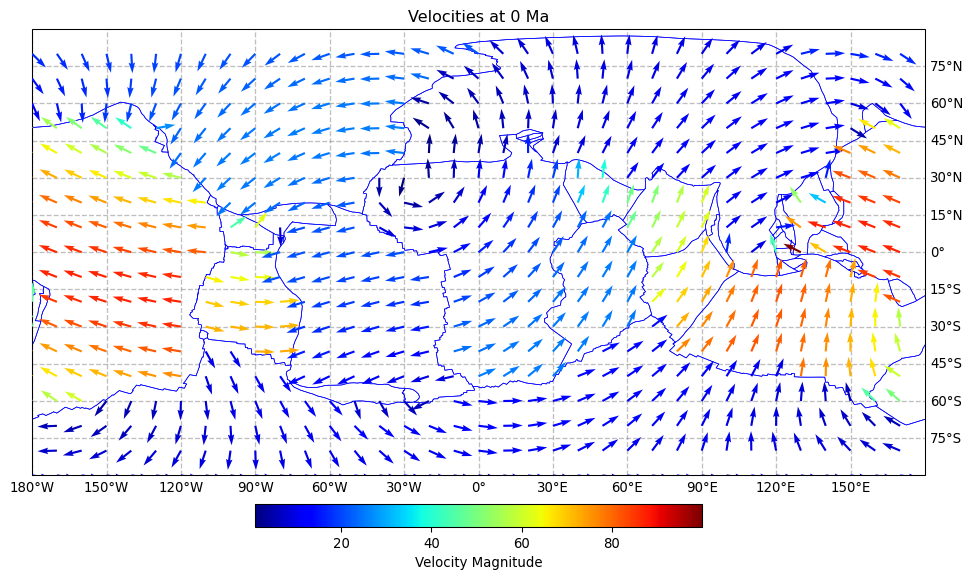

In [3]:
#setup the map, choose your projection
fig = plt.figure(figsize=(12,8),dpi=96)
#ax = plt.axes(projection=ccrs.Orthographic(central_longitude=30, central_latitude=60))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0))
#ax = plt.axes(projection=ccrs.Mollweide(central_longitude=0))
#ax = plt.axes(projection=ccrs.Robinson(central_longitude=0))


#set up the map's grid lines
#The cartopy has not implemented the grid line labels properly. 
#So, if you see the labels messed up, it is cartopy's fault.
#set draw_labels to False if the labels look no good.
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlocator = mticker.FixedLocator(range(-180,180,30))
gl.ylocator = mticker.FixedLocator(range(-90,90,15))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.top_labels = False
gl.left_labels = False


#plot topological plates boundaries
for t in resolved_topologies:
    lat, lon =zip(*(t.get_resolved_boundary().to_lat_lon_list()))
    plt.plot(lon, lat,
         color='blue', linewidth=.5, #the topological plates boundaries in blue
         transform=ccrs.Geodetic(),
    )
   

#plot coastlines
if draw_coastlines_as_polyline:
    for geom in reconstructed_geometries:
        lat, lon =zip(*(geom.get_reconstructed_geometry().to_lat_lon_list()))
        plt.plot(lon, lat,
             color='black', linewidth=.5, #the coastlines in black
             transform=ccrs.Geodetic(),
        )
elif draw_coastlines_as_polygon:#plot continent polygons            
    date_line_wrapper = pygplates.DateLineWrapper(0.0)
    for polygon in reconstructed_geometries:
        wrapped_polygons = date_line_wrapper.wrap(polygon.get_reconstructed_geometry())
        for poly in wrapped_polygons:
            ring = LinearRing([(p.get_longitude(), p.get_latitude()) for p in poly.get_exterior_points()])
            ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='gray', edgecolor='black', linewidth=0.5, alpha=0.5)     
 
########################################
cb=None
method=1
#
# LOOK HERE!!!! NOW, PLOT ARROWS
# choose one method and copy the code into your plot code
#
if method==1:
    x,y,u,v = velocity_tools.get_velocity_x_y_u_v(time,pygplates.RotationModel(rotation_files),topology_files)
    cb = velocity_tools.plot_velocities_uv(x,y,u,v,ax)
    
elif method==2:
    x,y,velocities = velocity_tools.get_velocities(time,pygplates.RotationModel(rotation_files),topology_files)
    cb = velocity_tools.plot_velocities(x,y,velocities,ax)

elif method==3: 
    x,y,velocities = velocity_tools.get_velocities(time,pygplates.RotationModel(rotation_files),
                                                   topology_files, 
                                                   delta_time=1, #see here !!!
                                                   Xnodes = np.arange(-180,180,5), #see here!!!
                                                   Ynodes = np.arange(-90,90,5))#see here!!!
    cb = velocity_tools.plot_velocities(x,y,velocities,ax)
    
elif method==4:
    x,y,u,v = velocity_tools.get_velocity_x_y_u_v(time,pygplates.RotationModel(rotation_files),topology_files,
                                                    delta_time=.5, #see here !!!
                                                    Xnodes = np.arange(0,180,10), #see here!!!
                                                    Ynodes = np.arange(0,90,10))#see here!!!)
    cb = velocity_tools.plot_velocities_uv(x,y,u,v,ax)
###############################################    
    

#plot title, color bar, etc...
plt.title(f'Velocities at {time} Ma')
if cb:
    fig.colorbar(cb, shrink=0.5, label='Velocity Magnitude', orientation="horizontal", pad=0.05)
plt.show()